# Bike Sharing Competition
### by: Rama Salahat
***


in this notebook we're using data from https://www.kaggle.com/c/bike-sharing-demand/overview
that precisely tracks hourly bike rental data spanning two years for the first 19 days of each month. <br><br>
We're going to do an EDA and feature engineer the data to better fit the following models: 
- simple linear regression
- ridge regression
- k-nn
- decision tree

and try to predict future values for the total count of bikes rented during each hour 


<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3948/media/bikes.png" alt="Bike Sharing Competition" />

## Table of Contents
- [**Ground Truths About Data**](#facts)
- [**EDA and Feature Engineering**](#EDA)
    - [Importing packages and reading the data](#import)
    - [Log Transform](#log)
    - [Distributions of the bookings according to the features](#features)
    - [Distribution of booking by Hours and Day-of-Week Together](#dayhour)
    - [Weather-Related values Collerence](#weather)
    - [Is the workingday atribute enough?](#workingday)
    - [Hot-Encoding the Weather and Season attributes](#hot)
    - [Dropping Useless Columns](#drop)
- [**Machine Learning Models**](#ML)
    - [Linear Regression](#linear)
    - [Linear Regression-polynomial features](#linearp)
    - [Ridge](#ridge)    
    - [Decision Tree](#tree)
    - [K-nn](#knn)

    

## Ground Truths About Data <a class="anchor" id="facts"></a>

 - seasons column's values stand for: 
1. spring
2. summer
3. fall
4. winter 


 - weather stands for: 
1. Clear, Few clouds, Partly cloudy, Partly cloudy
2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 


 - temp - temperature in Celsius
 - atemp - "feels like" temperature in Celsius
 - casual - number of non-registered user rentals initiated
 - registered - number of registered user rentals initiated
 - count - number of total rentals



***

# EDA and Feature Engineering <a class="anchor" id="EDA"></a>

### Importing packages and reading the data <a class="anchor" id="import"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
import warnings
warnings.filterwarnings("ignore")


In [2]:
#reading data
data = pd.read_csv("train.csv")
data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


<div class="alert alert-block alert-info">

the datetime column is type object, so it needs some engineering
</div>

In [4]:
#reformatting the datetime feature
data['datetime'] = pd.to_datetime(data['datetime'],format='%Y-%m-%d %H:%M:%S')

#add new columns from the datetime column
data['month'] = data['datetime'].dt.month 
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour 
data['dayofweek'] = data['datetime'].dt.dayofweek 

data = data.drop(["datetime"],axis=1)

In [5]:
data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,hour,dayofweek
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,6.521495,9.992559,11.541613,3.013963
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,3.444373,5.476608,6.915838,2.004585
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,4.000000,5.000000,6.000000,1.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,7.000000,10.000000,12.000000,3.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,10.000000,15.000000,18.000000,5.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,12.000000,19.000000,23.000000,6.000000


- it appears that there's no nulls or missing values in the dataframe
- it appears that there's some outliers in the (casual, registered and count) columns since the max value is a lot higher than the 75%(quartile) value
- the rest of the columns appear to be normally distributed


### Log Transform  <a class="anchor" id="log"></a>
#### Let's look at the outliers in casual, registered and count using frequency plots

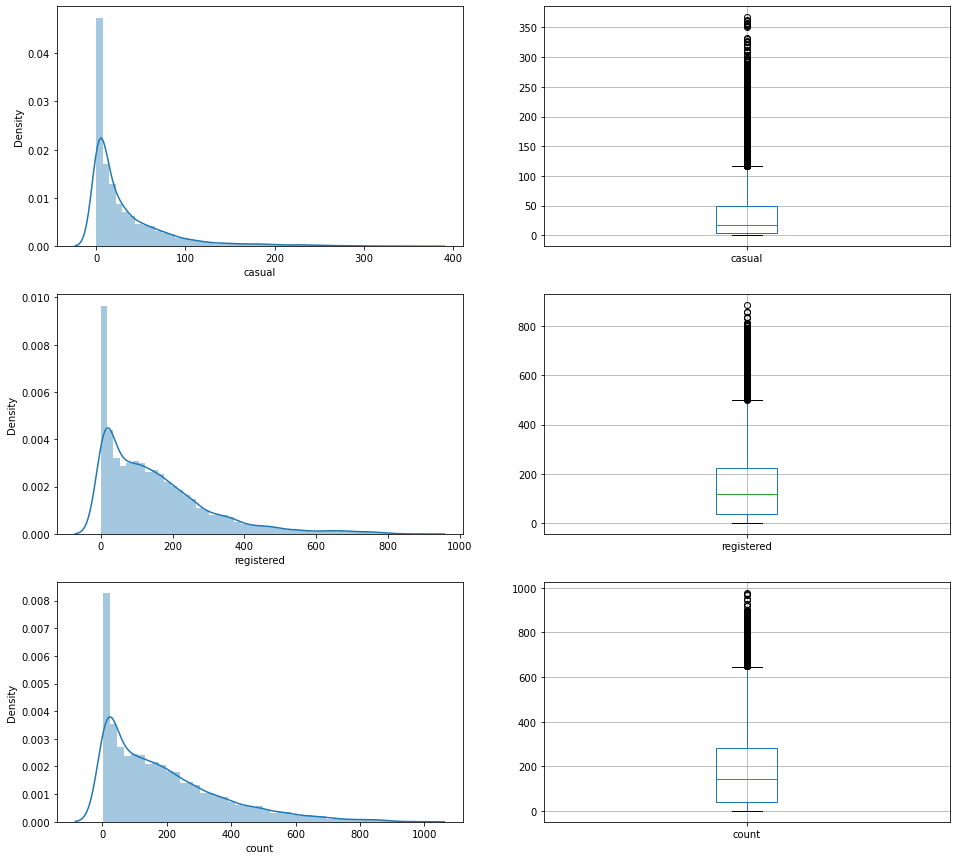

In [6]:
fig, ax = plt.subplots(3,2, figsize=(16,15))

#casual customers distribution plots
sns.distplot(data["casual"],ax=ax[0][0])
data.boxplot("casual", ax=ax[0][1])

#registered customers distribution plots
sns.distplot(data["registered"], ax=ax[1][0])
data.boxplot("registered", ax=ax[1][1])

#all customers distribution plots
sns.distplot(data["count"], ax=ax[2][0])
data.boxplot("count", ax=ax[2][1])

fig.show()

<div class="alert alert-block alert-info">
it's obvious that the three columns are positively skewed, let's use <b>log transform </b> to normalize the distribution a bit.
</div>

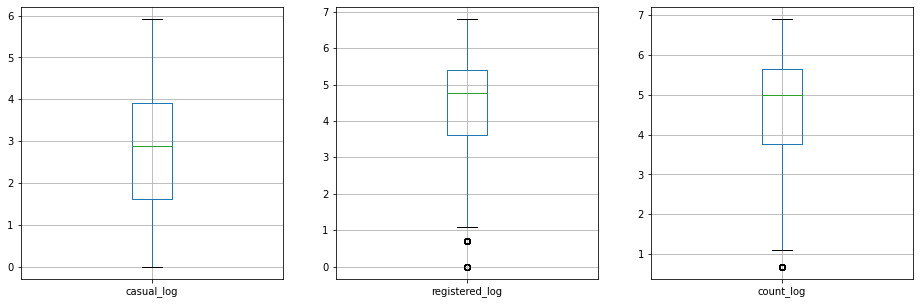

In [7]:
#normalizing columns(casual, registered and count)
data['casual_log'] = np.log((1+ data['casual']))
data['registered_log'] = np.log((1+ data['registered']))
data['count_log'] = np.log((1+ data['count']))

#resulting distributing
fig, ax = plt.subplots(1,3, figsize=(16,5))
data.boxplot("casual_log", ax=ax[0])
data.boxplot("registered_log", ax=ax[1])
data.boxplot("count_log", ax=ax[2])

fig.show()

<div class="alert alert-block alert-success">
these almost normally distributed values will be used in the ML models later in this notebook. 
</div>

## Distributions of the bookings according to the features: <a class="anchor" id="features"></a>
 - season 
 - month
 - day
 - day of the week 
 - hour
 - weather 
 - windspeed
 - temp
 - humidity

and see how the bookings are distributed into casual and registered for each category

<div class="alert alert-block alert-info">
First let's look at the correlation matrix to get an overview of how the variable are connected
</div>

<AxesSubplot:>

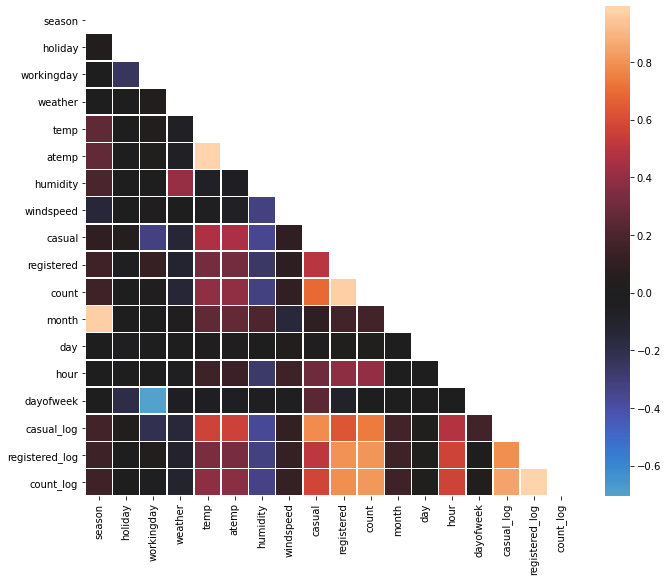

In [8]:
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap
sns.heatmap(corr, mask=mask, center=0,
            square=True, linewidths=.5)


<div class="alert alert-block alert-success">
you can see that there's some <b>slight correlation</b> between some values, but the correlation for each feature is too small to make the prediction dependent on one value, which is why a machine learning model is needed.
</div>

In [9]:
def plot_category_with_user_type(category): 
    ''' 
    function to plot inputed category with its count, casual and registered distributions
    input: category name
    output: showing 3 plots for count, casual and registered respectively
    '''
    #set plot up
    fig, ax = plt.subplots(1,3, figsize=(16,5), sharey=True)
    #title
    fig.suptitle("User Distribution According To " + category, fontsize=14)
    #plot 3 plots for count,casual and registered customers 
    sns.barplot(x = category, y = "count", data = data, ax = ax[0])
    sns.barplot(x = category, y = "casual", data = data, ax = ax[1])
    sns.barplot(x = category, y = "registered", data = data, ax = ax[2])
    fig.show()

### By season

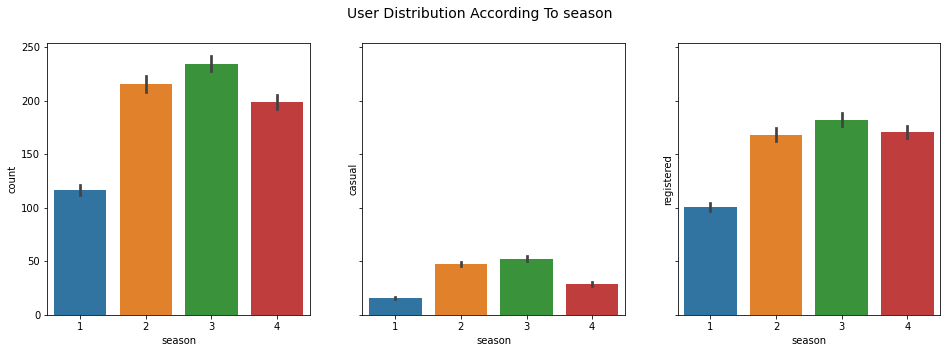

In [10]:
plot_category_with_user_type("season")

### By Month

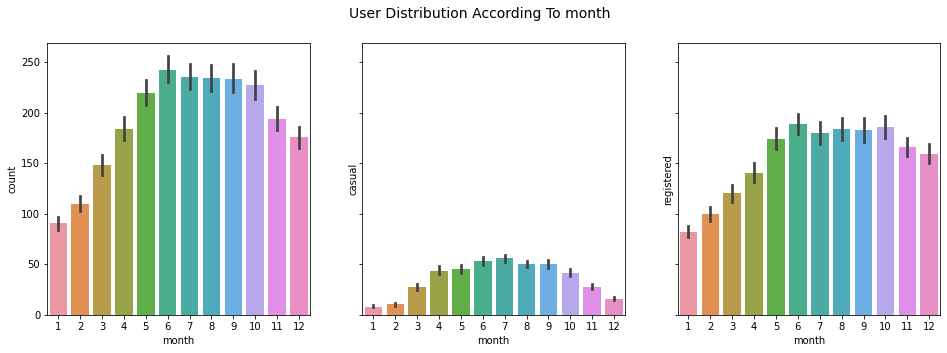

In [11]:
plot_category_with_user_type("month")

users (registered and casual) show a <b>pattern through the seasons</b>, bookings are at their lowest in the spring (season1), they peak in summer and fall(season2+3), and fall a bit in winter(season4).<br>
matching results show in the months distribution.


## By Day <a class="anchor" id="months"></a>

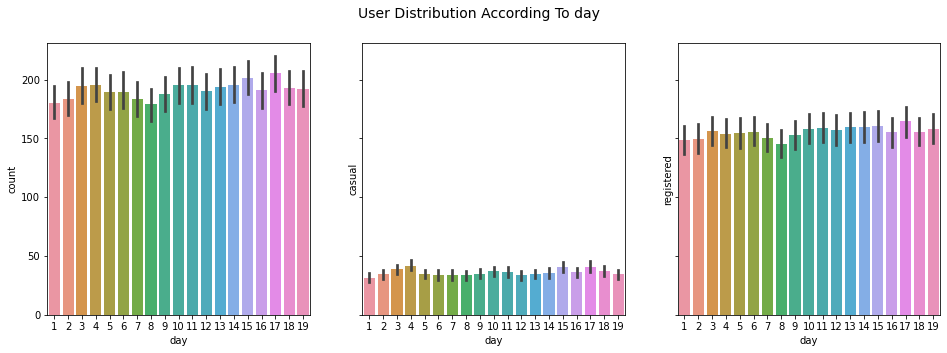

In [12]:
plot_category_with_user_type("day")

### The distribution is <b>consistent throughout the month</b> 

### - By Day Of Week <a class="anchor" id="weeks"></a>

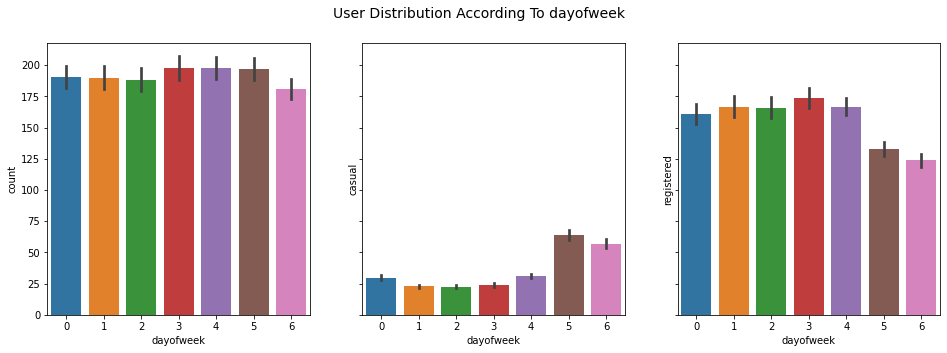

In [13]:
plot_category_with_user_type("dayofweek")


 - The number of bookings is consistent in general throughout the week for the company, but there's a slight fall on sunday which is a holiday.<br> 
 - There's a pattern among casual non-registering users, there's a peak of usage on saturday and sunday, probably because saturday is the end of the week which means high traffic, and friday is the weekend. 
 - There's a pattern among registered users, the booking are consistent throughout the week except fot saturday and sunday, which can be the result of multiple reasons that need to be considered in later research : 
     1. There isn't enough bikes because of the higher demand on bikes by non-registered users near weekends which means more bikes should be introduced to the system.
     2. Regular users might not be enjoying the experience so much which can result on only using the bikes when flexability and speed are needed rather for leisure.

### - By Hour

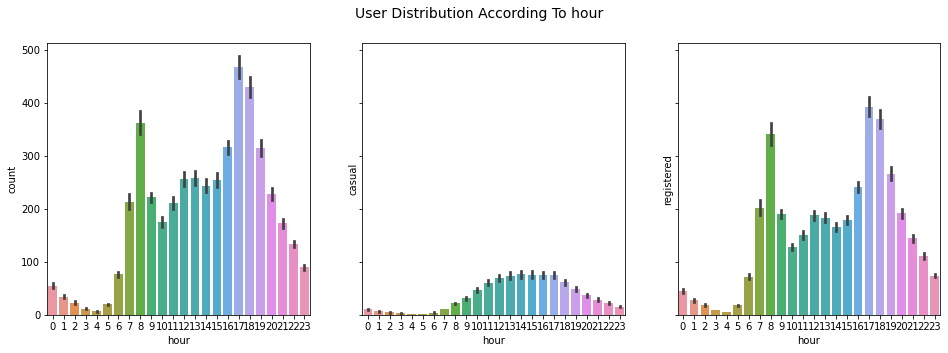

In [14]:
plot_category_with_user_type("hour")

 - casual users usually use bikes in the middle of the day and consistently peak from 12-6pm
 - registered users bookings peak at 8am and 5-6pm which strenghthens the theory that they use bikes for work rather than leisure.

### - By Weather

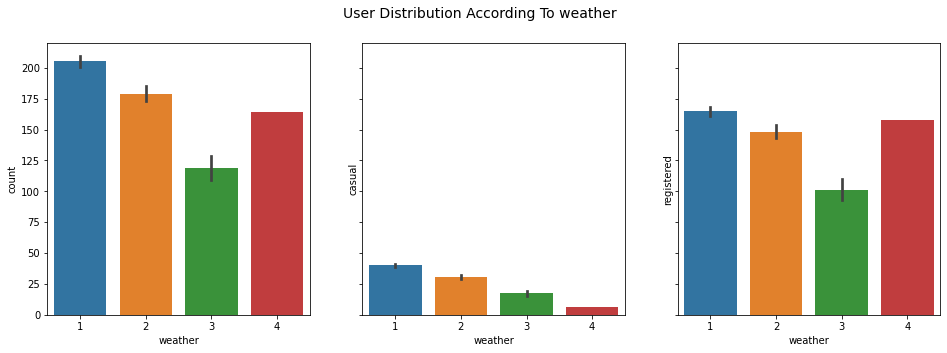

In [15]:
plot_category_with_user_type("weather")

 - casual users tend to book more when the weather is better
 - registered users surprisingly book consistently except when the weather is "Light Snow, light rain..."(number3)
 
 the difference in patterns strengthenes the theory of different purposes between registered and casual users
 

### - By Windspeed

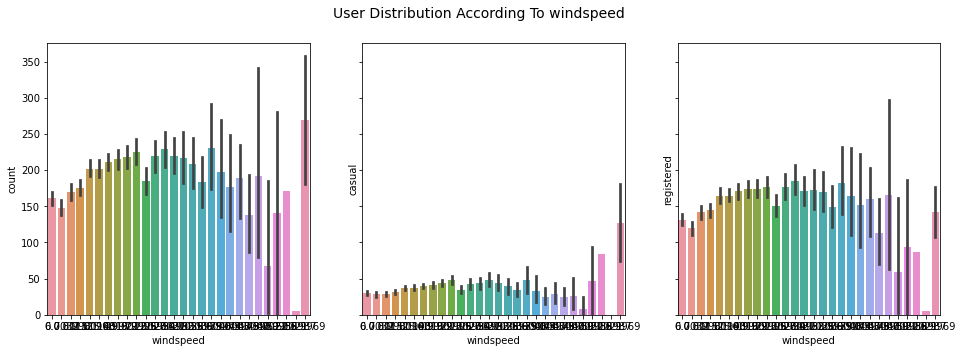

In [16]:
plot_category_with_user_type("windspeed")

the distribution is almost consistent regardless of the windspeed except for a couple of outliers.<br>
Windspeed should be excluded.

### - By Temp


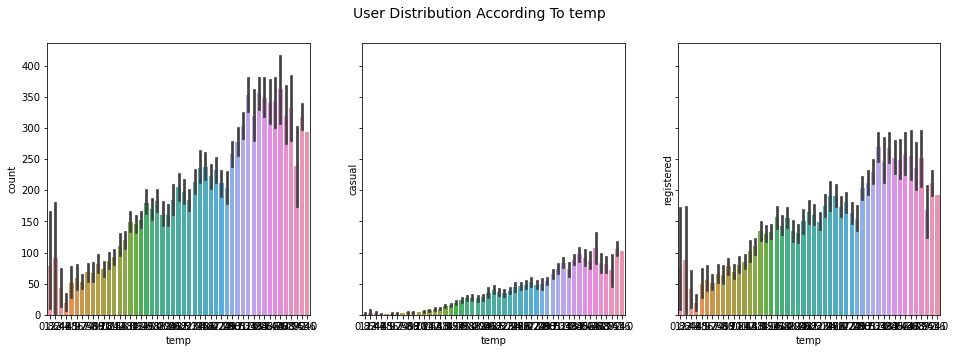

In [17]:
plot_category_with_user_type("temp")

 there's a clear connection between the tempreture and the increasing bookings.

### - By Humidity

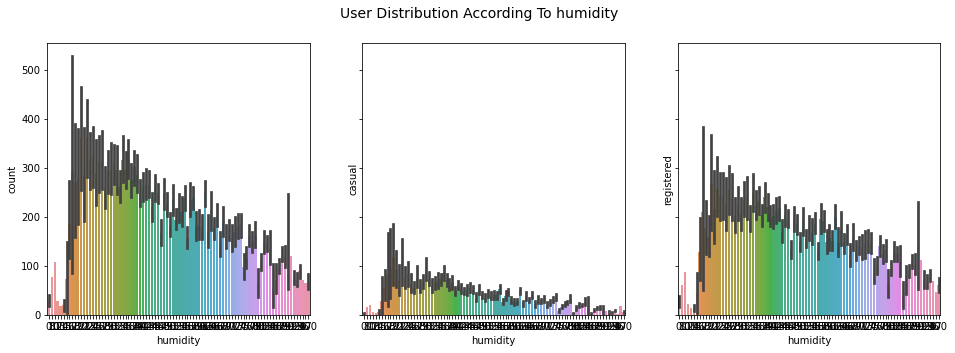

In [18]:
plot_category_with_user_type("humidity")

people tend to rent bikes when the humidity is lower than usual, but the change isn't that drastic and the variance is big

### Distribution of booking by Hours and Day-of-Week Together <a class="anchor" id="dayhour"></a>

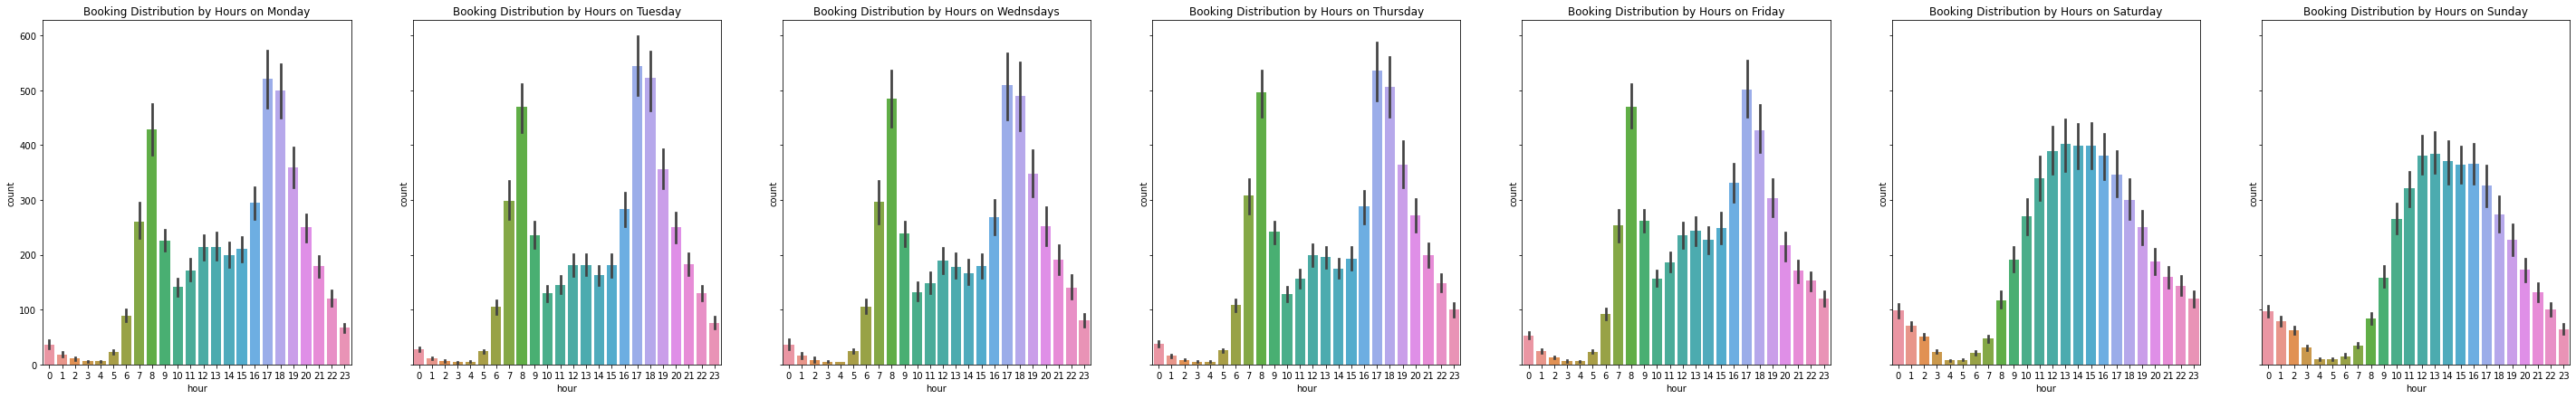

In [19]:
#setting plot up
fig, ax = plt.subplots(1,7, figsize=(50,7), sharey=True)

days=["Monday", "Tuesday", "Wednsdays", "Thursday", "Friday","Saturday", "Sunday"]

for i in range(7): 
    #split data according to week-day
    day_data= data[data["dayofweek"] == i]
    #plot day's dstribution
    sns.barplot(x = "hour", y = "count", data = day_data, ax = ax[i]).set_title("Booking Distribution by Hours on " + days[i])
fig.show()

the distribution is almost consistent in workdays and peaks on start and end times of typical jobs, but it changes in the weekend and becomes distributed throughout the day peaking in the middle of the day.

## Weather-Related values Collerence  <a class="anchor" id="weather"></a>
### Let's take a look at "atemp" and answer these questions
- is atemp always bigger than the real tempreture?
- is there a connection between atemp and humidity? if the answer to the first question is yes can the reason be humidity?
- should we use it in the models?


In [20]:
#calculate the difference between temp and atemp
averege_diff_atemp_and_temp = data["atemp"] - data["temp"]
#binarize the resulting values to classify as bigger or smaller
averege_diff_atemp_and_temp[averege_diff_atemp_and_temp >= 0] = 1
averege_diff_atemp_and_temp[averege_diff_atemp_and_temp < 0] = 0
#sum the result to calculate the precentage of atemps higher than temps
sum(averege_diff_atemp_and_temp) / len(averege_diff_atemp_and_temp)

0.9908138893992283

<div class="alert alert-block alert-success">
    so yes,<b> 99%</b> of the times atemp is <b>greater</b> than the real tempreture!
</div>

In [21]:
#calculate the correlation between temp, atemp and humidity
correlation = data[["temp", "atemp", "humidity"]].corr()
correlation

,temp,atemp,humidity
temp,1.000000,0.984948,-0.064949
atemp,0.984948,1.000000,-0.043536
humidity,-0.064949,-0.043536,1.000000


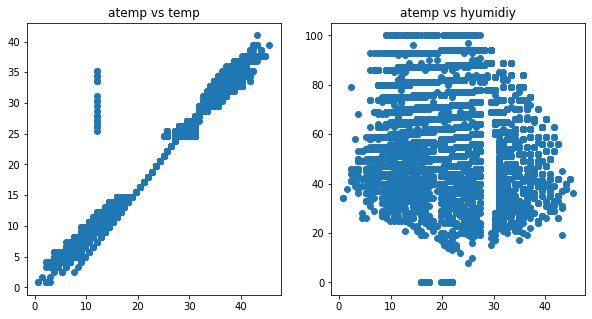

In [22]:
fig = plt.figure(figsize=(10,5))
plt1 = fig.add_subplot(121)
plt2 = fig.add_subplot(122)

#naming plots
plt1.set_title('atemp vs temp')
plt2.set_title('atemp vs hyumidiy')
#ploting plots
plt1.scatter(data["atemp"], data["temp"])
plt2.scatter(data["atemp"], data["humidity"])
plt.show()

by looking at the correlation values and the scatter plot, atemp and temp are clearly correlated while atemp and humidity not correlated at all.
<div class="alert alert-block alert-success">
since atemp is highly correlated with temp with a 99% rate, <b>atemp won't be used in building the models</b> and will be dropped.
</div>

In [23]:
#dropping atemp
data = data.drop(["atemp"],axis=1)

### Is there a correlence between the season, temperature, weather, windspeed and the humidity?

In [24]:
#calculating correlence array for the attributes bellow
correlation = data[["season","temp", "weather", "windspeed", "humidity"]].corr()
correlation

,season,temp,weather,windspeed,humidity
season,1.000000,0.258689,0.008879,-0.147121,0.190610
temp,0.258689,1.000000,-0.055035,-0.017852,-0.064949
weather,0.008879,-0.055035,1.000000,0.007261,0.406244
windspeed,-0.147121,-0.017852,0.007261,1.000000,-0.318607
humidity,0.190610,-0.064949,0.406244,-0.318607,1.000000


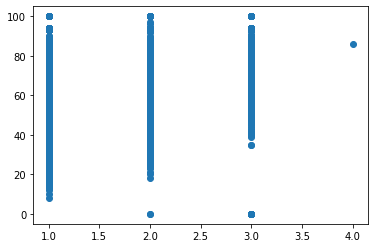

In [25]:
plt.scatter(data["weather"], data["humidity"])

<div class="alert alert-block alert-info">
as you can see there's no significant correlation between the weather, temperature, weather, windspeed and humidity, so all features will be used in the model
</div>

### Is the workingday atribute enough? (deleting day, dayofweek and holiday) <a class="anchor" id="workingday"></a>

<div class="alert alert-block alert-info">
    <b>let's look at the distibution of bookings in holidays, is it similar to regular days?</b>    
</div>

<AxesSubplot:xlabel='hour', ylabel='count'>

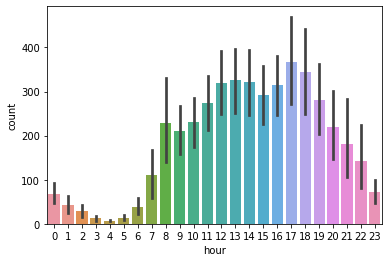

In [26]:
#plotting the holidays distribution excluding the weekends 
holiday_data = data[(data["holiday"]==1) & (data["dayofweek"]<5)]

sns.barplot(x = "hour", y = "count", data = holiday_data)

as seen above, The booking distribution in holidays is very similar to [weekends](#dayhour), and the workingday bolean atribute is taking this variable in account (it's 1 when the day isn't a holiday or a weekend).<br>
<div class="alert alert-block alert-success">
    <b>there's no need for the holiday attribute</b>
</div>

[We've previously seen](#months) that the distribution of bookings is consistent throughout the month regardles of the days number which leads us to believe that:
<div class="alert alert-block alert-success">
    <b>there's no need for the day attribute</b>
</div>

[We've also seen](#weeks) that the distribution among weeks is consistent, and is about the same for all days except for weekends. which is considered in the workday attribute, leads us to believe that: 
<div class="alert alert-block alert-success">
    <b>there's no need for the dayofweek attribute</b>
</div>

### Hot-Encoding the Weather and Season attributes  <a class="anchor" id="hot"></a>

<div class="alert alert-block alert-info">
Weather and Season attributes are categorical, which makes them unacceptable for a lot of models, we will use Hot-encoding to turn these categorical values into binary valueS for each label
    </div>

In [104]:
hot_encoded_data = data.join(pd.get_dummies(data["season"], prefix="season")).join(pd.get_dummies(data["weather"], prefix="weather"))
hot_encoded_data.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,count,...,registered_log,count_log,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,1,0,0,1,9.84,81,0.0,3,13,16,...,2.639057,2.833213,1,0,0,0,1,0,0,0
1,1,0,0,1,9.02,80,0.0,8,32,40,...,3.496508,3.713572,1,0,0,0,1,0,0,0
2,1,0,0,1,9.02,80,0.0,5,27,32,...,3.332205,3.496508,1,0,0,0,1,0,0,0
3,1,0,0,1,9.84,75,0.0,3,10,13,...,2.397895,2.639057,1,0,0,0,1,0,0,0
4,1,0,0,1,9.84,75,0.0,0,1,1,...,0.693147,0.693147,1,0,0,0,1,0,0,0


### Dropping Useless Columns <a class="anchor" id="drop">

In [105]:
hot_encoded_data = hot_encoded_data.drop(["count", "registered","casual"],axis=1)
hot_encoded_data = hot_encoded_data.drop(["holiday", "dayofweek"],axis=1)
hot_encoded_data = hot_encoded_data.drop(["month", "season", "weather", "windspeed"],axis=1)

*** 
# Machine Learning Models <a class="anchor" id="ML">

In the next section we will be trying out the following machine learning models: 
 - Linear Regression
 - Linear Regression - polynomial features
 - Ridge
 - Descion tree
 - K-nn

In [29]:
#importing packages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

In [30]:
def partition_data(full_data):
    ''' 
    takes a dataframe and seperates it into train and test data by splitting it by "day" 
    input: full dataframe
    output: x-axis training set
    output: y-axis training set
    output: x-axis test set
    output: x-axis test set    
    '''
    #split data by day
    train_data = full_data[data["day"]<15]
    test_data = full_data[data["day"]>14]

    #dropping the day column
    train_data = train_data.drop(["day"],axis=1)
    test_data = test_data.drop(["day"],axis=1)
    
    #splitting the training data into x and y axises
    x_train = train_data.drop(["casual_log", "count_log", "registered_log"],axis=1)
    y_train = train_data[["count_log"]]

    #splitting the test data into x and y axises
    x_test = test_data.drop(["casual_log", "count_log", "registered_log"],axis=1)
    y_test = test_data[["count_log"]]
    
    return x_train, y_train, x_test, y_test

In [31]:
def build_model(data, model, plot = False, tuning_parameter = 1):
    '''
    build and return model and MSE according to the entered keyword
    input: full dataframe
    input: model keyword
    input: boolean value to draw a plot or not -optional-
    input: tuning parameter for the model
    output: the model
    output: MSE value
    '''
    #split data using the previous function
    x_train, y_train, x_test, y_test = partition_data(data)
    
    #models dictionary
    models={
        "linear" : LinearRegression(),
        "ridge" : Ridge(alpha = tuning_parameter),
        "knn" : KNeighborsRegressor(n_neighbors = tuning_parameter),
        "decision_tree" : DecisionTreeRegressor(random_state=42)
    }
    
    #initiate model
    lModel = models[model]
    #fit the training data in the model
    lModel.fit(X = x_train, y = y_train)
    
    #predict new values
    y_predicted=lModel.predict(X= x_test) 

    #calculate MSE
    MSE = mean_squared_error(y_test, y_predicted)
    
    #plot real vs predicted values if the plot boolean is true
    if (plot):
        plt.figure(figsize=(5, 5))
        plt.scatter(y_test, y_predicted)
        plt.ylabel("predicted values")
        plt.xlabel("real values")
        #find min and max in the test target values
        minimum = math.ceil(y_test.min())
        maximum = math.ceil(y_test.max())
        #plot a diagonal line accross the scattered plot to better see the difference in values
        #idealy all points should be on the diagonal line
        plt.plot( [minimum,maximum],[minimum,maximum], color='red')

    return lModel, MSE

## Linear Regression <a class="anchor" id="linear">

(LinearRegression(), 1.0628100620860084)

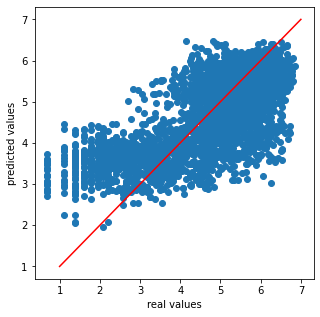

In [99]:
#build a linear model and plot the result
build_model(hot_encoded_data, "linear", plot = True)

<div class="alert alert-block alert-info">
Let's try to use polynomial features to improve the model
    </div>

## Linear Regression-polynomial features <a class="anchor" id="linearp">

In [114]:
from sklearn.preprocessing import PolynomialFeatures

#set up the polynomial fearues object
polynomial_fearues = PolynomialFeatures(degree=4, interaction_only=True)

polynomial_fearures_data = hot_encoded_data[["workingday", "hour", "temp", "humidity"]]

#make polynomial features out of the data
polynomial_fearues = polynomial_fearues.fit_transform(polynomial_fearures_data)
#turn the result into a dataframe
intr_features = pd.DataFrame(polynomial_fearues)

In [115]:
list_of_MSEs = []
list_of_thetas = []

#for each column in the polynomial fearues dataset: append it to the data and test the model
for (columnName, columnData) in intr_features.iteritems():
    polynomial_hypothesis_data = hot_encoded_data.drop(["workingday", "hour", "temp", "humidity"],axis=1)
    #appending the column
    polynomial_hypothesis_data["polynomial_factor"] = columnData
    
    #build model and assess it
    model, MSE = build_model(polynomial_hypothesis_data, "linear")
    
    list_of_MSEs.append(MSE)
    list_of_thetas.append(model.coef_)
    
list_of_MSEs

[1.8770857444412652,
 1.8777416981218686,
 1.224738701548065,
 1.6230744477390837,
 1.6645035366448349,
 1.6104269271701983,
 1.8559347852469816,
 1.8536754621650737,
 1.1547874093987074,
 1.5046535075150507,
 1.8795640158755127,
 1.5794410954221116,
 1.6861600240620729,
 1.8718088863195979,
 1.4148024539900923,
 1.6564947090743378]

<div class="alert alert-block alert-info">
The MSEs values are bigger when using polynomial features than when using simple linear regression, so we will ignore them.
   </div>

## Ridge <a class="anchor" id="ridge">

In [106]:
#partition data to find the best tunning parameter
x_train, y_train, x_test, y_test = partition_data(hot_encoded_data)

#this object can find the best alpha to be used for this model
regr_cv = RidgeCV(alphas=[0.1, 1.0, 5.0, 10.0, 20, 25, 30, 40, 50, 100, 200, 500, 1000, 2000])

model_cv = regr_cv.fit(x_train, y_train)
model_cv.alpha_

25.0

1.0615542569135017

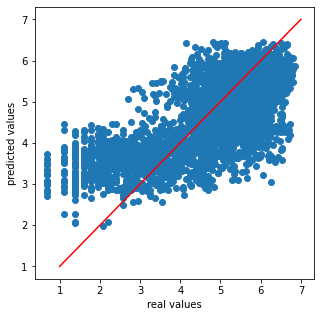

In [107]:
#build ridge model with the found alpha
model, MSE = build_model(hot_encoded_data, "ridge", tuning_parameter = 25, plot = True)
MSE

## Decision Tree  <a class="anchor" id="tree">

0.3766852084770444

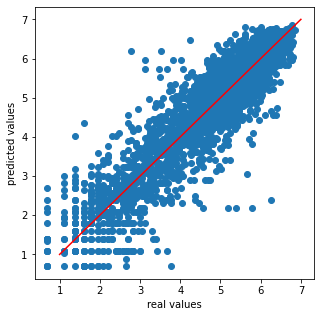

In [121]:
#prepare data for the model
tree_data = data.drop(["month", "count", "registered","casual","holiday", "dayofweek", "windspeed"],axis=1)
#build and assess model
model, MSE =build_model(tree_data, "decision_tree", plot = True)
MSE

In [118]:
#packages for visuallizing the decision tree
from sklearn import tree
import graphviz
from IPython.display import SVG
from IPython.display import display

Text(0.5, 0, 'features')

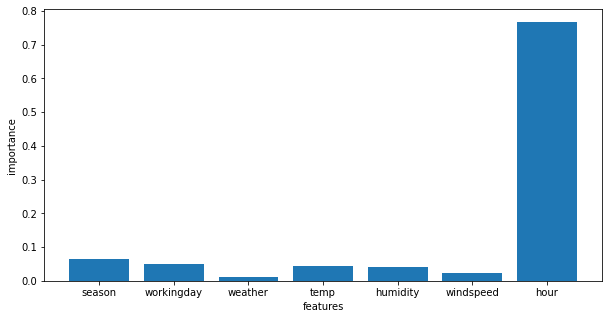

In [119]:
#find columns names
columns = tree_data.drop(["casual_log", "count_log", "registered_log", "day"],axis=1).columns

#plot each feature with its importance in the model
plt.figure(figsize=(10, 5))
plt.bar(columns, model.feature_importances_)
plt.ylabel("importance")
plt.xlabel("features")


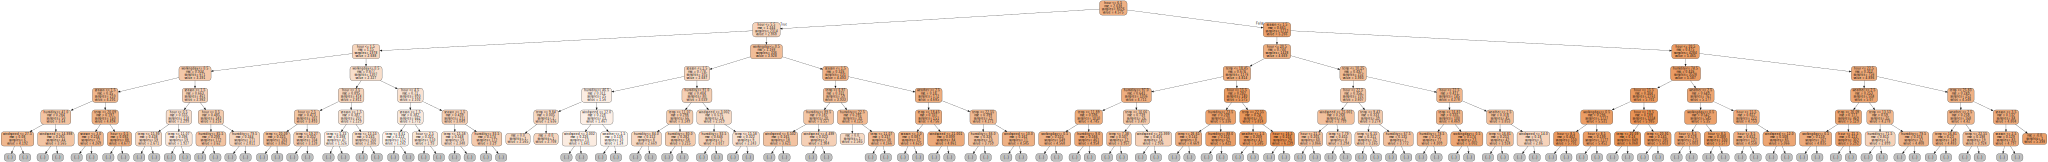

In [120]:
#plotting the decision tree
tree_data = tree.export_graphviz(model, feature_names = columns, filled=True, rounded=True,max_depth=6)

graph = graphviz.Source(tree_data)
display(SVG(graph.pipe(format='svg')))

## K-NN  <a class="anchor" id="knn">

In [43]:
#scalling the target data for the K-nn model
scaler = StandardScaler()
general_data = hot_encoded_data[["casual_log", "count_log", "registered_log"]]
scaler.fit(general_data)
scaled = scaler.transform(general_data)
scaled = pd.DataFrame(data=scaled, columns = general_data.columns)

#turning the target log value into int because K-nn doesn't work with float values
scaled["casual_log"] = (scaled["casual_log"] * 10) .apply(np.floor)
scaled["registered_log"] = (scaled["registered_log"] * 10) .apply(np.floor)
scaled["count_log"] = (scaled["count_log"] * 10) .apply(np.floor)

#join the new columns
general_data = general_data.join(hot_encoded_data.drop(["casual_log", "count_log", "registered_log"],axis=1))

In [44]:
#finding the best k value
k_values = [3, 4, 5, 6, 7, 8, 9, 10, 15, 30]

MSEs_values =[]
models = []

for k_value in k_values: 
    #build and assess model
    model, MSE = build_model(general_data, "knn", tuning_parameter = k_value)
    MSEs_values.append(MSE)
    models.append(model)
MSEs_values

[0.4835776054038456,
 0.4692311366918119,
 0.45762899613432667,
 0.4502693503320887,
 0.44792126300134716,
 0.45000777945266013,
 0.4571563125729741,
 0.46146141586512374,
 0.4806859450054849,
 0.5412064647497242]

<b>7</b> is the best value for k 

(KNeighborsRegressor(n_neighbors=7), 0.44792126300134716)

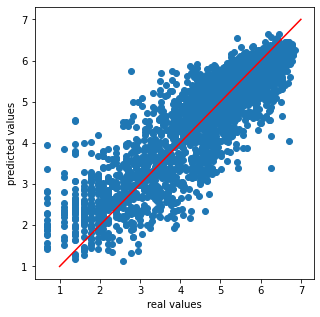

In [45]:
build_model(general_data, "knn", tuning_parameter = 7, plot = True)